<a href="https://colab.research.google.com/github/sri123vk/Movie-Recommendation-System-Movielens-dataset/blob/main/CNN_MRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
1418/1418 [==============================] - 9s 5ms/step - loss: 0.6378 - val_loss: 0.6212
Epoch 2/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6133 - val_loss: 0.6192
Epoch 3/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6085 - val_loss: 0.6145
Epoch 4/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6067 - val_loss: 0.6125
Epoch 5/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6071 - val_loss: 0.6114


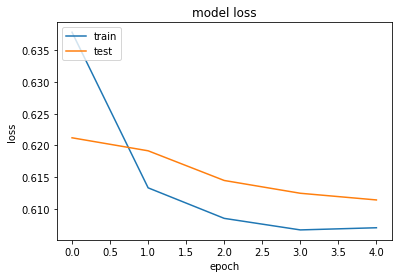

Showing recommendations for user: 332
Movies with high ratings from user
--------------------------------
Blade Runner (1982) : Action|Sci-Fi|Thriller
Groundhog Day (1993) : Comedy|Fantasy|Romance
Matrix, The (1999) : Action|Sci-Fi|Thriller
Memento (2000) : Mystery|Thriller
Moulin Rouge (2001) : Drama|Musical|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
One Flew Over the Cuckoo's Nest (1975) : Drama
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Godfather: Part II, The (1974) : Crime|Drama
Office Space (1999) : Comedy|Crime
Departed, The (2006) : Crime|Drama|Thriller
Django Unchai

In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pickle

ratings = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])
df_movies = movies 
df_ratings = ratings
df=ratings
movie_df=movies

user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)

min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)
    